In [ ]:
!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

import bayes_helpers as bh

In [ ]:
# Start writing code here...

# need to change the way the weights are reshaped
class LunaFeedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'D_final_out' : architecture['final_output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        
        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width']) #number of weights/biases between input and first hidden layer
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim']) #number of weights/biases between last hidden layer and output
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width']) #number of weights/biases between each pair of hidden layers
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))

    # for LUNA, need to discard aux functions
    def forward(self, weights, x, final_layer_out=False):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        #making sure the middle dimension is D_in
        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output) #apply activation func

            assert input.shape[1] == H

        #last hidden layer
        final_layer = np.array(input, copy = True)

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        
        # final_layer_out = True when we are using forward to predict, NOT training
        if final_layer_out:
            return final_layer
        # final_layer_out
        else:
            return output

    def get_aux_funcs(self, W):
        res_w, res_b = [], []
        D, D_out, H = self.D, self.params['D_out'], self.params['H']
        index = D - (D_out*H + D_out) - 1
        for m in range(D_out):
            w_m = W[0][index + H*m:index + H*(m+1)]
            b_m = W[0][index + H*(m+1)]
            index += 1
            res_w.append(w_m)      
            res_b.append(b_m)
            
        #res_w is a list of lists
        #res_b is a list of numbers
        return res_w, res_b

    def similarity_score(self, W):
        # f is a vectorized function, x is a vector
        # needs to return a vector
        def grad_finite_diff(f, x):
            dx = 0.001
            return (f(x + dx) - f(x))/dx

        def cos_sim_sq(fi, fj, x): 
            # returns 1 when fi parallel to fj
            # returns 0 when fi perpendicular to fj
            grad_i = grad_finite_diff(fi, x)
            grad_j = grad_finite_diff(fj, x)
            numerator = np.dot(grad_i, grad_j.T)**2
            denominator = np.dot(grad_i, grad_i.T) * np.dot(grad_j, grad_j.T)
            frac = numerator/denominator
            return frac

        # calculate square of cosine similarity for each pair of aux functions
        score = 0
        final_hidden_layer = self.forward(W, x_train, final_layer_out=True, aux = True)
        aux_func_weights, aux_func_biases = self.get_aux_funcs(W)
        for i in range(self.params['D_out']):
            w_i = aux_func_weights[i]
            b_i = aux_func_biases[i]
            f_i = lambda x : np.matmul(w_i, x) + b_i#applying aux weights w_i to last hidden layer
            for j in range(i + 1, self.params['D_out']):
                w_j = aux_func_weights[j]
                b_j = aux_func_biases[j]
                f_j = lambda x : np.matmul(w_j, x) + b_j#applying aux weights w_j to last hidden layer
                score += cos_sim_sq(f_i, f_j, final_hidden_layer)
        
        return score
    
    def mean_mean_sq_error(self, W):
        aux_outputs = self.forward(W, x_train) #shape = (1,10,12)
        Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

        # calculate squared error for each aux regressor, take mean
        mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

        return mse

    # for LUNA, this needs to use aux functions
    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            # L_luna(model) = L_fit(model) - lambda*L_diverse(model)
            lambda_ = 0.1
            gamma_ = reg_param
            L_sim = lambda_*self.similarity_score(W)

            regularization_penalty = gamma_*np.linalg.norm(W)**2
            mean_mse = self.mean_mean_sq_error(W)
            L_fit = mean_mse - regularization_penalty
            return L_fit - L_sim

        return objective, grad(objective)

    # for LUNA, this needs to use aux functions
    # by default, the fit function applies l2-regularization with a param of 0.1
    def fit(self, x_train, y_train, params, reg_param = 0.1):

        assert x_train.shape[0] == self.params['D_in']
        #assert y_train.shape[0] == self.params['D_final_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam' # DEFAULT. CHANGE IN PARAMS
        opt_gradient = self.gradient # DEFAULT. CHANGE IN PARAMS
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if  'opt_gradient' in params.keys():
            gradient = params['opt_gradient']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        # AM205 CREW: gradient is used here
        for i in range(random_restarts):

            # this is the default
            if optimizer == 'adam':
                adam(opt_gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]


In [ ]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 7
hidden_layers = 2
input_dim = 1
output_dim = 10 #number of auxiliary functions
final_output_dim = 1


architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'final_output_dim' : final_output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = LunaFeedforward(architecture, random=random)

In [ ]:
df = pd.read_csv("HW8_data.csv")
x_train = np.array(df["x"])
y_train = np.array(df["y"])
x_test = np.linspace(x_train.min()-1,x_train.max()+1,200)

x_train = x_train.reshape((1, -1))
y_train = y_train.reshape((1, -1))
x_test = x_test.reshape((1, -1))

In [ ]:
#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

###define design choices in gradient descent

#from having run this a few times, seems like 2500 iterations is a good amount. but this may depend on the other params :/

params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1,
          'optimizer':'adam'}
#nn.fit(x_train, y_train, params)

In [ ]:
from utils import run_toy_nn

run_toy_nn(LunaFeedforward,architecture,params,random,x_train,y_train,x_test)

Iteration 0 lower bound [[888.68161547]]; gradient mag: 2081.130319109057
Iteration 100 lower bound [[469.74761216]]; gradient mag: 1334.2646008789827
Iteration 200 lower bound [[253.77959224]]; gradient mag: 895.8900655879667
Iteration 300 lower bound [[135.40309107]]; gradient mag: 613.9669517530178
Iteration 400 lower bound [[68.86918655]]; gradient mag: 417.13410813304665
Iteration 500 lower bound [[32.08817985]]; gradient mag: 273.39177361827285
Iteration 600 lower bound [[12.1112154]]; gradient mag: 169.15606717844253
Iteration 700 lower bound [[0.76499986]]; gradient mag: 97.5614073210017
Iteration 800 lower bound [[-6.68961698]]; gradient mag: 52.40698083338497
Iteration 900 lower bound [[-12.08150268]]; gradient mag: 26.403174251733983
Iteration 1000 lower bound [[-15.90354843]]; gradient mag: 12.797853524547804
Iteration 1100 lower bound [[-19.00191413]]; gradient mag: 7.730563331027035
Iteration 1200 lower bound [[-22.03030252]]; gradient mag: 6.08328051605766
Iteration 1300

NameError: name 'plt' is not defined

In [ ]:
nn = LunaFeedforward(architecture, random=random)

#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)

#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)
print(x_test.flatten().reshape(-1,1).shape)
#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')


plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

NameError: name 'y_test_pred' is not defined

In [ ]:
# Recommendation: make X and Y inputs to the train function instead of the NLM constructor 
# so that the same model could be re-trained on new datasets 

from scipy.stats import multivariate_normal
from feed_forward import Feedforward

class LUNA():
    """
    Fits LUNA Model
    
    Model Assumptions
     - Weights distributed normally
     - Ys distributed normally


     How to use:
      - run train() to create: 
            a) the NN MLE weights, found in self.ff.weights 
            b) self.posterior samples, the distribution for the weights in the last layer of NLM
     
      - run predict() to get distribution of ys, given x test
    """
    def __init__(self,X,Y,prior_var,y_noise_var,architecture, random_state):

        self.lff = Feedforward(architecture, random = random_state) #CHANGE
        
        self.X = X # X training
        self.Y = Y # Y training data
        
        self.prior_var = prior_var # prior variance final layer weights
        self.y_noise_var = y_noise_var # variance of noise, distributed normally

    def train(self):
        
        # Fit Weights
        self.lff.fit(self.X, self.Y, params)

        # Transform X with Feature Map for Bayes Reg
            #evaluated NN up to lst layer by setting final_layer_out to True
        fm_x_matrix = self.lff.forward(self.lff.weights, self.X, final_layer_out=True)
        
        # Conduct Bayes Reg on Final Layer 
        self.posterior_samples = bh.get_bayes_lr_posterior(self.prior_var,
                                                        self.y_noise_var,
                                                        fm_x_matrix.T[:,:,0], #fm_x_matrix, 
                                                        self.Y.T,
                                                        samples=100)

        print("Done Training")
    
    def predict(self,X_test):

        # forward pass up to last layer
        fm_x_matrix = self.lff.forward(self.lff.weights, X_test, final_layer_out=True)
        print(fm_x_matrix.T[:,:,0].shape)
        # get posterior predictives, posterior of final layer weights
        return bh.get_bayes_lr_posterior_predictives(self.y_noise_var,self.posterior_samples,fm_x_matrix.T[:,:,0])

    def get_aux_funcs(self, W):
        res_w, res_b = [], []
        D, D_out, H = self.D, self.params['D_out'], self.params['H']
        index = D - (D_out*H + D_out) - 1
        for m in range(D_out):
            w_m = W[0][index + H*m:index + H*(m+1)]
            b_m = W[0][index + H*(m+1)]
            index += 1
            res_w.append(w_m)      
            res_b.append(b_m)
            
        #res_w is a list of lists
        #res_b is a list of numbers
        return res_w, res_b


    def similarity_score(self, W):
        # f is a vectorized function, x is a vector
        # needs to return a vector
        def grad_finite_diff(f, x):
            dx = 0.001
            return (f(x + dx) - f(x))/dx

        def cos_sim_sq(fi, fj, x): 
            # returns 1 when fi parallel to fj
            # returns 0 when fi perpendicular to fj
            grad_i = grad_finite_diff(fi, x)
            grad_j = grad_finite_diff(fj, x)
            numerator = np.dot(grad_i, grad_j.T)**2
            denominator = np.dot(grad_i, grad_i.T) * np.dot(grad_j, grad_j.T)
            frac = numerator/denominator
            return frac

        # calculate square of cosine similarity for each pair of aux functions
        score = 0
        final_hidden_layer = self.forward(W, x_train, final_layer_out=True, aux = True)
        aux_func_weights, aux_func_biases = self.get_aux_funcs(W)
        for i in range(self.params['D_out']):
            w_i = aux_func_weights[i]
            b_i = aux_func_biases[i]
            f_i = lambda x : np.matmul(w_i, x) + b_i#applying aux weights w_i to last hidden layer
            for j in range(i + 1, self.params['D_out']):
                w_j = aux_func_weights[j]
                b_j = aux_func_biases[j]
                f_j = lambda x : np.matmul(w_j, x) + b_j#applying aux weights w_j to last hidden layer
                score += cos_sim_sq(f_i, f_j, final_hidden_layer)
        
        return score
    
    def mean_mean_sq_error(self, W):
        aux_outputs = self.forward(W, x_train) #shape = (1,10,12)
        Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

        # calculate squared error for each aux regressor, take mean
        mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

        return mse

    # for LUNA, this needs to use aux functions
    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            # L_luna(model) = L_fit(model) - lambda*L_diverse(model)
            lambda_ = 0.1
            gamma_ = reg_param
            L_sim = lambda_*self.similarity_score(W)

            regularization_penalty = gamma_*np.linalg.norm(W)**2
            mean_mse = self.mean_mean_sq_error(W)
            L_fit = mean_mse - regularization_penalty
            return L_fit - L_sim

        return objective, grad(objective)

        



In [ ]:
# test
prior_var = 1.0
y_var = 2.0
test_luna = LUNA(x_train, y_train, prior_var,y_var, architecture, random_state = np.random.RandomState(0))

In [ ]:
test_luna.train()
posterior_predictives, posterior_predictive_samples = test_luna.predict(x_test)

Iteration 0 lower bound [[4317.13123622]]; gradient mag: 8006.452126483383
Iteration 100 lower bound [[1702.14720813]]; gradient mag: 4275.369428724128
Iteration 200 lower bound [[721.83507175]]; gradient mag: 2409.812419489686
Iteration 300 lower bound [[324.56556835]]; gradient mag: 1415.3510749089103
Iteration 400 lower bound [[156.7219972]]; gradient mag: 857.252774400587
Iteration 500 lower bound [[83.17189534]]; gradient mag: 528.4369113751939
Iteration 600 lower bound [[49.67515363]]; gradient mag: 326.46962757618365
Iteration 700 lower bound [[33.24086795]]; gradient mag: 203.06173792907356
Iteration 800 lower bound [[24.54164613]]; gradient mag: 125.91667112071974
Iteration 900 lower bound [[20.3081267]]; gradient mag: 29.796996710693588
Done Training
(200, 5)


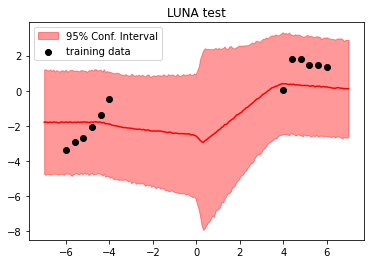

In [ ]:
viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,"LUNA test")

In [ ]:
# LUNA v1.5
from feed_forward import Feedforward
from nlm import NLM

class LUNA():
    """
    Fits LUNA Model
    
    Model Assumptions
     - Weights distributed normally
     - Ys distributed normally

     How to use:
      - run train() to create: 
            a) the NN MLE weights, found in self.ff.weights 
            b) self.posterior samples, the distribution for the weights in the last layer of NLM
     
      - run predict() to get distribution of ys, given x test
    """
    def __init__(self,prior_var,y_noise_var,architecture, random_state):

        self.ff = Feedforward(architecture, random = random_state)
        
        self.prior_var = prior_var # prior variance final layer weights
        self.y_noise_var = y_noise_var # variance of noise, distributed normally

    def train(self, X, Y, params):
        
        # Fit Weights
        self.ff.fit(X,Y, params)

        # Transform X with Feature Map for Bayes Reg
            #evaluated NN up to lst layer by setting final_layer_out to True
        final_layer = self.ff.forward(self.ff.weights, X, final_layer_out=True)
        
        # Conduct Bayes Reg on Final Layer 
        self.posterior_samples = bh.get_bayes_lr_posterior(self.prior_var,
                                                        self.y_noise_var,
                                                        final_layer.T[:,:,0], 
                                                        Y.T,
                                                        samples=100)

        print("Done Training")
    
    def predict(self, X_test):

        # forward pass up to last layer
        fm_x_matrix = self.ff.forward(self.ff.weights, X_test, final_layer_out=True)
        print(final_layer.T[:,:,0].shape)
        # get posterior predictives, posterior of final layer weights
        return bh.get_bayes_lr_posterior_predictives(self.y_noise_var,self.posterior_samples,final_layer.T[:,:,0])

    def get_aux_funcs(self, W):
        res_w, res_b = [], []
        D, D_out, H = self.D, self.params['D_out'], self.params['H']
        index = D - (D_out*H + D_out) - 1
        for m in range(D_out):
            w_m = W[0][index + H*m:index + H*(m+1)]
            b_m = W[0][index + H*(m+1)]
            index += 1
            res_w.append(w_m)      
            res_b.append(b_m)
            
        #res_w is a list of lists
        #res_b is a list of numbers
        return res_w, res_b


    def similarity_score(self, W):
        # f is a vectorized function, x is a vector
        # needs to return a vector
        def grad_finite_diff(f, x):
            dx = 0.001
            return (f(x + dx) - f(x))/dx

        def cos_sim_sq(fi, fj, x): 
            # returns 1 when fi parallel to fj
            # returns 0 when fi perpendicular to fj
            grad_i = grad_finite_diff(fi, x)
            grad_j = grad_finite_diff(fj, x)
            numerator = np.dot(grad_i, grad_j.T)**2
            denominator = np.dot(grad_i, grad_i.T) * np.dot(grad_j, grad_j.T)
            frac = numerator/denominator
            return frac

        # calculate square of cosine similarity for each pair of aux functions
        score = 0
        final_hidden_layer = self.forward(W, x_train, final_layer_out=True, aux = True)
        aux_func_weights, aux_func_biases = self.get_aux_funcs(W)
        for i in range(self.params['D_out']):
            w_i = aux_func_weights[i]
            b_i = aux_func_biases[i]
            f_i = lambda x : np.matmul(w_i, x) + b_i#applying aux weights w_i to last hidden layer
            for j in range(i + 1, self.params['D_out']):
                w_j = aux_func_weights[j]
                b_j = aux_func_biases[j]
                f_j = lambda x : np.matmul(w_j, x) + b_j#applying aux weights w_j to last hidden layer
                score += cos_sim_sq(f_i, f_j, final_hidden_layer)
        
        return score
    
    def mean_mean_sq_error(self, W):
        aux_outputs = self.forward(W, x_train) #shape = (1,10,12)
        Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

        # calculate squared error for each aux regressor, take mean
        mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

        return mse

    # for LUNA, this needs to use aux functions
    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            # L_luna(model) = L_fit(model) - lambda*L_diverse(model)
            lambda_ = 0.1
            gamma_ = reg_param
            L_sim = lambda_*self.similarity_score(W)

            regularization_penalty = gamma_*np.linalg.norm(W)**2
            mean_mse = self.mean_mean_sq_error(W)
            L_fit = mean_mse - regularization_penalty
            return L_fit - L_sim

        return objective, grad(objective)